# Gradient Boosting with Random Forests and related topics

In this last notebook, we will explore the Gradient Boosting technique for classification. This technique combines the principles of gradient boosting and random forests by sequentially fitting decision trees to the errors of the previous trees, improving model accuracy while maintaining the benefits of ensemble methods.

### Import and preprocess data

In [1]:
#IMPORTS PACKAGES
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [2]:
path = os.path.join(os.getcwd(), 'EEG_mouse_data.csv')
data_mice = pd.read_csv(path)

In [3]:
def norm_0_1(data):
    # Calculate the minimum and maximum values for each column (feature)
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    #print(max_vals)
    
    # Perform min-max scaling
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data


#CREATE X AND Y FROM DATAFRAME
X = np.vstack([data_mice.iloc[i, 2:] for i in np.arange(len(data_mice))])
X = norm_0_1(X)
Y = data_mice['state'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### GradientBoostingClassifier

This time, the hyperparameters have already been fine-tuned, so you don't need to adjust them yourself. Simply execute the cell to train the model; it might take 1 or 2 minutes.

Q3.1: Two additional hyperparameters were added compared to the RandomForestClassifier. What are these hyperparameters, and what roles do they play?

As we can see, in the code, there are two additional parameters. We are referring here to the parameters “learning_rate” and “subsample”. Here is an explanation of each:
-	**learning_rate**  : This parameter scales the contribution of each tree to the final model. It essentially controls the step size at each iteration while moving toward a minimum of a loss function. Has seen until now in all the PW.
-	**subsample**  : This parameter specifies the fraction of samples to be used for fitting the trees. If it's less than 1.0, then each new tree in the ensemble is trained on a random subset of the data, which introduces more randomness into the model and can help prevent overfitting. 


In [4]:
from sklearn.ensemble import GradientBoostingClassifier

# Define hyperparameters for Gradient Boosting
hyperparameters_gb = {
    'n_estimators': 300,
    'learning_rate': 0.05, 
    'max_depth': 4,         
    'subsample': 0.5,
    'min_samples_leaf': 15,
    'max_features': 20,
}

# Create a Gradient Boosting classifier with the specified hyperparameters
gb_classifier = GradientBoostingClassifier(**hyperparameters_gb,random_state=0)

# Fit the model on the training data
gb_classifier.fit(X_train, Y_train)
print('Gradient Boosting model trained')

Gradient Boosting model trained


### FINAL MODEL EVALUATION

Accuracy on Training Set: 0.9556954214488461
Accuracy on Test Set: 0.9123889437314906
Classification Report for Training Set:
              precision    recall  f1-score       support
n              0.954428  0.964212  0.959295   5365.000000
r              0.954663  0.686220  0.798483   1074.000000
w              0.956461  0.980649  0.968404   9767.000000
accuracy       0.955695  0.955695  0.955695      0.955695
macro avg      0.955184  0.877027  0.908728  16206.000000
weighted avg   0.955669  0.955695  0.954128  16206.000000
Classification Report for Test Set:
              precision    recall  f1-score      support
n              0.918782  0.920785  0.919782  1376.000000
r              0.751678  0.413284  0.533333   271.000000
w              0.918384  0.963825  0.940556  2405.000000
accuracy       0.912389  0.912389  0.912389     0.912389
macro avg      0.862948  0.765965  0.797890  4052.000000
weighted avg   0.907369  0.912389  0.906266  4052.000000


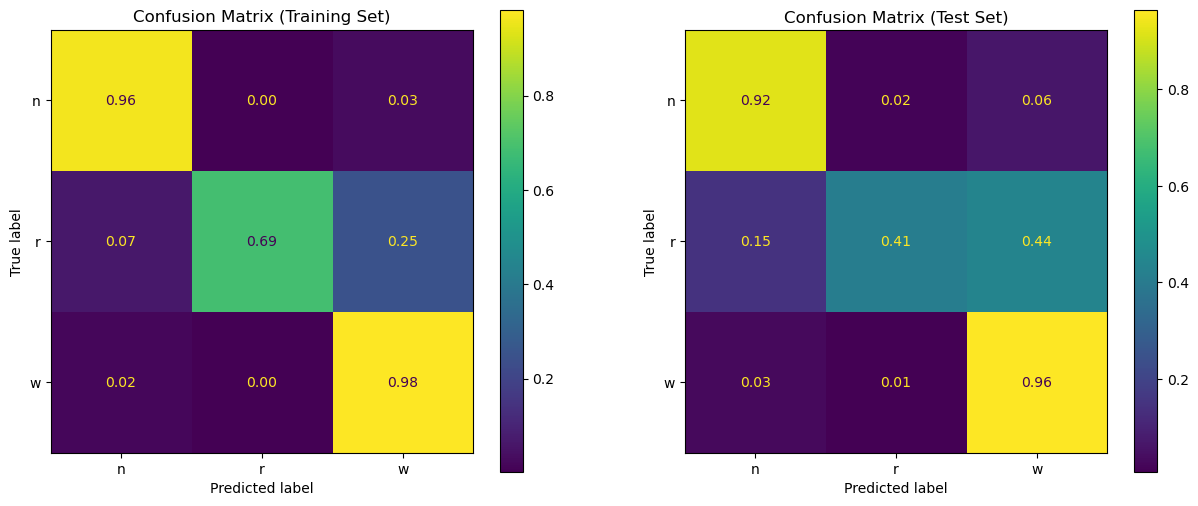

In [5]:
# Make predictions
train_prediction = gb_classifier.predict(X_train)
test_prediction = gb_classifier.predict(X_test)
test_prediction

# Calculate accuracy
train_accuracy = accuracy_score(Y_train, train_prediction)
test_accuracy = accuracy_score(Y_test, test_prediction)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix for the training set
cm_train = confusion_matrix(Y_train, train_prediction, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=gb_classifier.classes_)
_=disp_train.plot(ax=axs[0], values_format=".2f")
_=axs[0].set_title('Confusion Matrix (Training Set)')
# Confusion matrix for the test set
cm_test = confusion_matrix(Y_test, test_prediction, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=gb_classifier.classes_)
_=disp_test.plot(ax=axs[1], values_format=".2f")
_=axs[1].set_title('Confusion Matrix (Test Set)')

# Display accuracy for both sets
print('Accuracy on Training Set:', train_accuracy)
print('Accuracy on Test Set:', test_accuracy)

# Classification report for the training set
classification_metrics_train = classification_report(Y_train, train_prediction, output_dict=True)
report_df_train = pd.DataFrame(classification_metrics_train).transpose()
print("Classification Report for Training Set:")
print(report_df_train)

# Classification report for the test set
classification_metrics_test = classification_report(Y_test, test_prediction, output_dict=True)
report_df_test = pd.DataFrame(classification_metrics_test).transpose()
print("Classification Report for Test Set:")
print(report_df_test)

plt.show()

The cell above summarizes performance of the GradientBoostingClassifier.

Q3.2: Comment the results. Compare these results with the ones obtained with the RandomForestClassifier. Compare more specifically the precision, the recall and the f1-score of the 'r' class obtained with GradientBoostingClassifier and RandomForestClassifier. What are your conclusions?

Here is an overview of the results we had in the notebook : 
-	Overall Accuracy :
    - RF: Training: 88.88%, Testing: 86.96%
    - GB: Training: 95.57%, Testing: **91.24%**
Let’s now dive into the precison of the “r” class:
-	Precision (Class 'r'):
    - RF: Training: 48.59%, Testing: 39.75%
    - GB: Training: 95.47%, Testing: **75.17%**
-	Recall (Class 'r'):
    - RF: Training: 81.93%, Testing: **59.41%**
    - GB: Training: 68.62%, Testing: 41.33%
-	F1-Score (Class 'r'):
    - RF: Training: 61.00%, Testing: 47.63%
    - GB: Training: 79.85%, Testing: **53.33%**

**Conclusion** : 
Gradient Boosting emerges as a robust model, demonstrating superior overall performance characterized by higher accuracy and more balanced metrics across different classes. This superiority is especially pronounced in its precision in predicting instances of class 'r'. Precision, in this context, refers to the model's ability to correctly identify 'r' instances out of all instances it labeled as 'r'.

However, this high precision comes with a trade-off in recall, a measure of the model's ability to identify all actual instances of class 'r'. Here, Random Forest takes the lead, showcasing a higher recall for class 'r' compared to Gradient Boosting. This means that while Random Forest may incorrectly label more non-'r' instances as 'r' (lower precision), it is less likely to miss the 'r' instances (higher recall).

Choosing between these two models thus becomes a question of prioritizing precision over recall or vice versa, depending on the specific requirements and consequences associated with the predictive task.


NOTE: It is interesting to note that, in a real-world scenario, performances for this task could be further improved. For example, you could apply more advanced feature engineering techniques, or even incorporate other sensors, such as an electromyograph (EMG) for recording the electrical activity in skeletal muscles. Nevertheless, these aspects are beyond the scope of this practical work.